# Compare results with TrajGWAS.jl

+ `TrajGWAS.jl` software: https://github.com/OpenMendel/TrajGWAS.jl


In [1]:
using Revise
using QuasiCopula
using TrajGWAS
using CSV
using Glob
using PrettyTables
using GLM
using LinearAlgebra
using SnpArrays
using Suppressor
using ProgressMeter
using Random

using Plots
using MendelPlots
gr(fmt=:png)

ENV["COLUMNS"] = 240
BLAS.set_num_threads(1)
Threads.nthreads()

1

## Simulated data from QuasiCopula model

We simulate response from the QuasiCopula model. Also, all genotypes are simulated with no correlation

In [2]:
# simulate from quasicopula model
p = 15
n = 100000
plinkname = "test.data"
qc_model, G, βtrue, θtrue, γtrue, τtrue = simulate_longitudinal_traits(
    n = n, # sample size
    d_min = 5, # min number of observations per sample
    d_max = 5, # max number of observations per sample
    p = p, # number of fixed effects, including intercept
    m = 2, # number of variance components
    q = 1000, # number of SNPs
    k = 0, # number of causal SNPs
    seed = 2024,
    y_distribution = Bernoulli,
    τtrue = 0.5,
    T = Float64,
    maf = 0.3,
    causal_snp_β = 0.2,
    plinkdir = plinkname * ".bed",
);

# save plink bim/fam files
open(plinkname * ".bim", "w") do f
    for i in 1:size(G, 2)
        write(f, "1\tsnp$i\t0\t$(100i)\t1\t2\n")
    end
end
open(plinkname * ".fam", "w") do f
    for i in 1:size(G, 1)
        write(f, "sample$i\t1\t0\t0\t1\t-9\n")
    end
end

# save phenotype file (make sure to not save intercept)
data = zeros(5n, (p-1)+1) # (p-1) = covariates without intercept, +1 for response
for (i, qc) in enumerate(qc_model.data)
    rowrange = (i-1)*5+1:5i
    data[rowrange, 1:end-1] .= qc.X[:, 2:end]
    data[rowrange, end]     .= qc.y
end
df_names = vcat(["cov$i" for i in 1:14], "y")
df = DataFrame(data, df_names)
df[!, "id"] = repeat(["sample$i" for i in 1:n], inner=5)
CSV.write("test.data.response", df)

"test.data.response"

### Run TrajGWAS.jl and QuasiCopula.jl on data from QC model

In [18]:
cov_file = "test.data.response"
gen_file = "test.data" # PLINK file without .bed/bim/fam extensions
nullpath = "trajgwas.null.txt"
pvalpath = "trajgwas.pval.txt"
group_by = :id # rows with the same `group_by` are considered repeated meatures from sample subject

# trajGWAS with SPA
@time trajgwas(
    @formula(y ~ 1+cov1+cov2+cov3+cov4+cov5+cov6+cov7+cov8+cov9+cov10+cov11+cov12+cov13+cov14), # formula for mean effects
    @formula(y ~ 1), # formula for random effects
    @formula(y ~ 1), # formula for within-subject variance
    group_by,
    cov_file,
    gen_file,
    pvalfile = pvalpath, # output file for the gwas p-values
    nullfile = nullpath, # output file for the fitted null model
    usespa = true,       # use saddle point approximation or score test
    verbose = false
)
trajpval_spa = CSV.read(pvalpath, DataFrame)[!, "betapval"]

# trajGWAS no SPA
@time trajgwas(
    @formula(y ~ 1+cov1+cov2+cov3+cov4+cov5+cov6+cov7+cov8+cov9+cov10+cov11+cov12+cov13+cov14), # formula for mean effects
    @formula(y ~ 1), # formula for random effects
    @formula(y ~ 1), # formula for within-subject variance
    group_by,
    cov_file,
    gen_file,
    pvalfile = pvalpath, # output file for the gwas p-values
    nullfile = nullpath, # output file for the fitted null model
    usespa = false,       # use saddle point approximation or score test
    verbose = false
);
trajpval_score_test = CSV.read(pvalpath, DataFrame)[!, "betapval"]

# QuasiCopula GWAS
@time begin
    @suppress QuasiCopula.fit!(qc_model)
    qc_pvals, qc_zscores = QuasiCopula.GWASCopulaVCModel(qc_model, G, check_grad=true);
end

# compare p-values
[qc_pvals trajpval_score_test trajpval_spa]

run = 1, ‖Δβ‖ = 0.000601, ‖Δτ‖ = 0.000009, ‖ΔL‖ = 0.000006, status = LOCALLY_SOLVED, time(s) = 1.909617
run = 2, ‖Δβ‖ = 0.000000, ‖Δτ‖ = 0.000000, ‖ΔL‖ = 0.000000, status = LOCALLY_SOLVED, time(s) = 1.408000
 83.109539 seconds (55.25 M allocations: 156.962 GiB, 50.81% gc time)
run = 1, ‖Δβ‖ = 0.000601, ‖Δτ‖ = 0.000009, ‖ΔL‖ = 0.000006, status = LOCALLY_SOLVED, time(s) = 1.913159
run = 2, ‖Δβ‖ = 0.000000, ‖Δτ‖ = 0.000000, ‖ΔL‖ = 0.000000, status = LOCALLY_SOLVED, time(s) = 1.374993
 77.861234 seconds (55.22 M allocations: 156.954 GiB, 60.55% gc time)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:34


Wtime = 20.68990177612319
Qtime = 5.537908687374946
Rtime = 1.7034463456242142
grad_res_time = 2.8177918028761275
othertime = 1.1852890143747397
scoretest_time = 0.00108216575
 41.028210 seconds (441.06 M allocations: 19.487 GiB, 5.13% gc time, 0.02% compilation time)


1000×3 Matrix{Float64}:
 0.40455    0.908113   0.908113
 0.633252   0.522616   0.522616
 0.606728   0.461735   0.461735
 0.0831521  0.132857   0.132857
 0.800643   0.215992   0.215992
 0.665078   0.553992   0.553992
 0.192441   0.188337   0.188337
 0.105871   0.116886   0.116886
 0.230683   0.0665183  0.0665183
 0.776155   0.941696   0.941696
 0.380509   0.203663   0.203663
 0.787753   0.756115   0.756115
 0.157951   0.0570035  0.0570035
 ⋮                     
 0.293595   0.727732   0.727732
 0.828865   0.753999   0.753999
 0.846231   0.242526   0.242526
 0.0913148  0.298274   0.298274
 0.455756   0.79455    0.79455
 0.255181   0.208278   0.208278
 0.433709   0.546231   0.546231
 0.948826   0.36383    0.36383
 0.294605   0.156625   0.156625
 0.333591   0.342385   0.342385
 0.109911   0.172513   0.172513
 0.9957     0.854925   0.854925

### Compare p-values

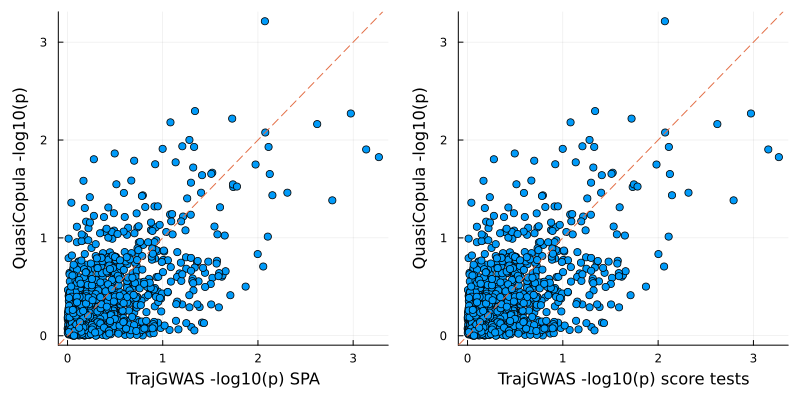

In [19]:
# compare -log10(p-values)
success_idx = findall(!isnan, qc_pvals)
plt1 = scatter(
    -log10.(trajpval_spa[success_idx]),
    -log10.(qc_pvals[success_idx]), 
    xlabel = "TrajGWAS -log10(p) SPA",
    ylabel = "QuasiCopula -log10(p)",
    label=false,
    size=(400, 400)
)
Plots.abline!(1, 0, line=:dash, label=false)

plt2 = scatter(
    -log10.(trajpval_score_test[success_idx]),
    -log10.(qc_pvals[success_idx]), 
    xlabel = "TrajGWAS -log10(p) score tests",
    ylabel = "QuasiCopula -log10(p)",
    label=false,
    size=(400, 400)
)
Plots.abline!(1, 0, line=:dash, label=false)

Plots.plot(plt1, plt2, size=(800, 400), bottom_margin=5Plots.mm, left_margin=5Plots.mm)

### QQ plots

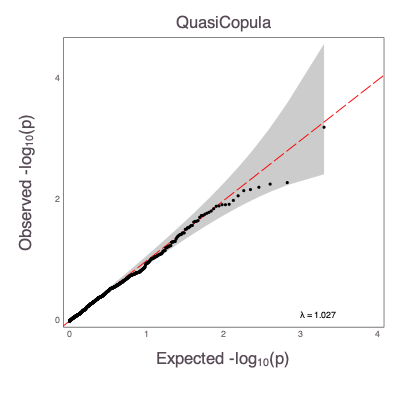

In [20]:
using MendelPlots
idx = findall(!isnan, qc_pvals)
success_pvals = qc_pvals[idx]
idx2 = findall(x -> x < 1e-50, success_pvals)
success_pvals[idx2] .= 1e-50
qq(success_pvals, dpi=80, titles="QuasiCopula")
display("image/png", read("qqplot.png"))

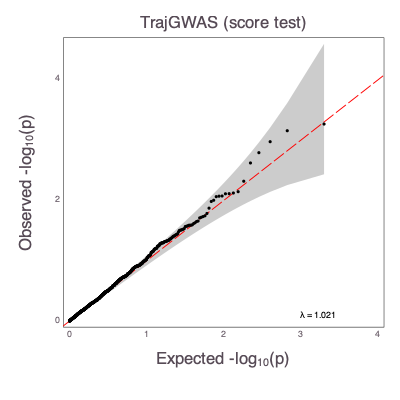

In [21]:
using MendelPlots
idx = findall(!isone, trajpval_score_test)
qq(trajpval_score_test[idx], dpi=80, titles="TrajGWAS (score test)")
display("image/png", read("qqplot.png"))

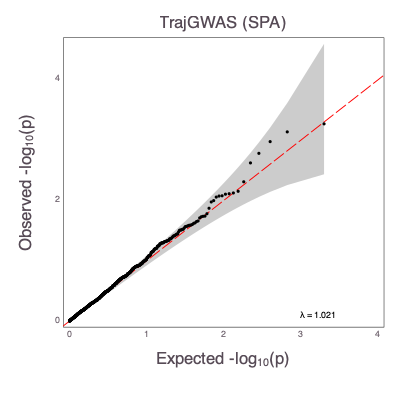

In [22]:
using MendelPlots
idx = findall(!isone, trajpval_spa)
qq(trajpval_spa[idx], dpi=80, titles="TrajGWAS (SPA)")
display("image/png", read("qqplot.png"))

# Hapmap test data

In [2]:
datadir = normpath(joinpath(dirname(pathof(TrajGWAS)), "../data/"))
readdir(glob"*.*", datadir)

14-element Vector{String}:
 "/Users/biona001/.julia/packages/TrajGWAS/R4aGq/data/bgen_snpsetfile.txt"
 "/Users/biona001/.julia/packages/TrajGWAS/R4aGq/data/covariate.txt"
 "/Users/biona001/.julia/packages/TrajGWAS/R4aGq/data/example.8bits.bgen"
 "/Users/biona001/.julia/packages/TrajGWAS/R4aGq/data/example.8bits.bgen.bgi"
 "/Users/biona001/.julia/packages/TrajGWAS/R4aGq/data/hapmap3.bed"
 "/Users/biona001/.julia/packages/TrajGWAS/R4aGq/data/hapmap3.bim"
 "/Users/biona001/.julia/packages/TrajGWAS/R4aGq/data/hapmap3.fam"
 "/Users/biona001/.julia/packages/TrajGWAS/R4aGq/data/hapmap_snpsetfile.txt"
 "/Users/biona001/.julia/packages/TrajGWAS/R4aGq/data/sim_data.jl"
 "/Users/biona001/.julia/packages/TrajGWAS/R4aGq/data/snpsetfile_vcf.txt"
 "/Users/biona001/.julia/packages/TrajGWAS/R4aGq/data/test_vcf.vcf.gz"
 "/Users/biona001/.julia/packages/TrajGWAS/R4aGq/data/trajgwas_bgen_ex.csv"
 "/Users/biona001/.julia/packages/TrajGWAS/R4aGq/data/trajgwas_plinkex.csv"
 "/Users/biona001/.julia/packages/T

## Run TrajGWAS.jl and QuasiCopula.jl

In [3]:
cov_file = joinpath(datadir * "trajgwas_plinkex.csv")
gen_file = joinpath(datadir * "hapmap3") # PLINK file without .bed/bim/fam extensions
nullpath = joinpath(pwd(), "trajgwas.null.txt")
pvalpath = "trajgwas.pval.txt"
group_by = :id # rows with the same `group_by` are considered repeated meatures from sample subject

# trajGWAS
@time trajgwas(
    @formula(y ~ 1 + sex + onMeds + snp1 + snp2 + snp3 + snp4), # formula for mean effects
    @formula(y ~ 1),                # formula for random effects
    @formula(y ~ 1 + sex + onMeds), # formula for within-subject variance
    group_by,
    cov_file,
    gen_file,
    pvalfile = pvalpath, # output file for the gwas p-values
    nullfile = nullpath, # output file for the fitted null model
    usespa = false,       # use saddle point approximation or score test
    verbose = false
);

# QuasiCopula GWAS
df = CSV.read(cov_file, DataFrame)
y = :y
d = Normal()
link = IdentityLink()
covariates = [:sex, :onMeds, :snp1, :snp2, :snp3, :snp4]
qc_model = VC_model(df, y, group_by, covariates, d, link)
@suppress QuasiCopula.fit!(qc_model)
G = SnpData(gen_file)
@time qc_pvals, _ = QuasiCopula.GWASCopulaVCModel(qc_model, G.snparray, check_grad=true);
# @time qc_pvals_true = QuasiCopula.GWASCopulaVCModel_autodiff_fast(qc_model, G.snparray, check_grad=true);

# compare p-values
trajGWAS_result = CSV.read(pvalpath, DataFrame)
[qc_pvals trajGWAS_result[!, "betapval"]]


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

run = 1, ‖Δβ‖ = 0.039033, ‖Δτ‖ = 0.320815, ‖ΔL‖ = 0.002056, status = LOCALLY_SOLVED, time(s) = 0.130037
run = 2, ‖Δβ‖ = 0.005078, ‖Δτ‖ = 0.047483, ‖ΔL‖ = 0.004220, status = LOCALLY_SOLVED, time(s) = 0.020068
 19.401234 seconds (89.88 M allocations: 5.946 GiB, 5.88% gc time, 152.79% compilation time: 2% of which was recompilation)


Progress: 100%|█████████████████████████████████████████| Time: 0:00:02


Wtime = 0.5218048133750005
Qtime = 0.32926987275000064
Rtime = 0.1637886246250007
grad_res_time = 0.04018571550000007
othertime = 0.03340009224999998
scoretest_time = 0.0023968990000000083
  3.565558 seconds (35.49 M allocations: 2.001 GiB, 5.12% gc time, 161.04% compilation time)


13928×2 Matrix{Float64}:
 NaN           1.0
   0.419156    0.689825
   0.00215944  0.915347
   5.88633e-8  0.539575
   1.0         1.0
 NaN           1.0
   0.729413    0.145089
   0.814897    0.2367
   5.62858e-7  0.147444
   0.865471    0.914766
 NaN           1.0
   0.536554    0.647976
   0.00238035  0.143678
   ⋮           
   0.0467219   0.996963
   0.0659461   0.976543
   0.0902896   0.912266
   0.0782111   0.979217
   0.105738    0.92517
   0.00449956  0.596064
   0.0924863   0.959083
   0.0982549   0.914567
   0.0928459   0.93992
   0.628908    0.318731
   0.698285    0.911726
   0.221815    0.719769

## QQ plots

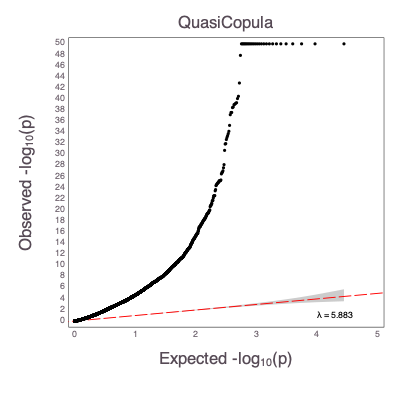

In [4]:
using MendelPlots
idx = findall(!isnan, qc_pvals)
success_pvals = qc_pvals[idx]
idx2 = findall(x -> x < 1e-50, success_pvals)
success_pvals[idx2] .= 1e-50
qq(success_pvals, dpi=80, titles="QuasiCopula")
display("image/png", read("qqplot.png"))

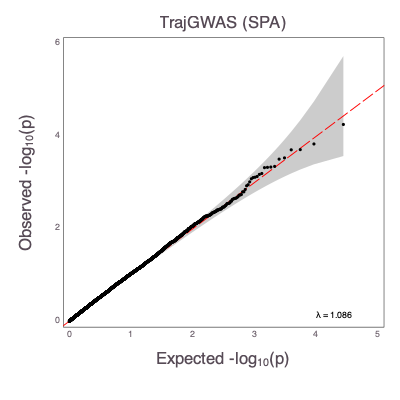

In [5]:
using MendelPlots
idx = findall(!isone, trajGWAS_result[!, "betapval"])
qq(trajGWAS_result[idx, "betapval"], dpi=80, titles="TrajGWAS (SPA)")
display("image/png", read("qqplot.png"))

# Simulate Hapmap data ourselves

+ source: https://github.com/OpenMendel/TrajGWAS.jl/blob/main/data/sim_data.jl

To understand why the p-values are deflated for QC model, lets simulate data ourselves following the routine in trajGWAS.jl

In [17]:
using SnpArrays, WiSER, TrajGWAS, Random, QuasiCopula, Suppressor
using DataFrames, CSV, Statistics, Distributions, GLM, LinearAlgebra, StatsBase

datadir = normpath(joinpath(dirname(pathof(TrajGWAS)), "../data/"))
gen_file = joinpath(datadir * "hapmap3") # plink file without bed/bim/fam extensions
covfile = "trajgwas_plinkex.csv"
pvalpath = "trajGWAS_pval.csv"

# PLINK data 
hapmap = SnpArray(gen_file * ".bed")
famids = CSV.read(gen_file * ".fam", DataFrame, header=false)[!, 1]
hapmap = convert(Matrix{Float64}, hapmap, model=ADDITIVE_MODEL, impute=true)
toplist = sortperm(vec(var(hapmap, dims=1))[1:12000], rev=true)[1:30]

# pick a few SNPs with not too much correlation 
# lastcor = 1
# for i in toplist, j in toplist #find most independent SNPs 
#     curcor = abs(Statistics.cor(@view(hapmap[:, i]), @view(hapmap[:, j])))
#     if curcor < lastcor
#         lastcor = curcor
#         println("$i and $j cor is $curcor")
#     end
# end

# simulation parameters
m, _ = size(hapmap)
ni = 10
Random.seed!(310)
sex = rand(0:1, m)
timeinvarX = [sex hapmap[:, 7828] hapmap[:, 8250] hapmap[:, 5] hapmap[:, 11793]] # time invariant covariates
p = 7
l = 7
q = 1

βtrue = [10.0; -3.2; 0.5; 0.5; 1.5; 0.25; 0.75]
τtrue = [0.2; -0.3; 0.5; -0.5; 0.5; 0.25; 0.15]
Σγ    = Matrix(Diagonal([10])) # does this mean γ ~ N(0, 2)? 
δγω   = [0.0]
σω    = [0.0]

Σγω   = [Σγ δγω; δγω' σω]
Lγω   = cholesky(Symmetric(Σγω), check = false).L
Lγ    = Lγω[1:q, 1:q]
lγω   = Lγω[q + 1, 1:q]
lω    = Lγω[q + 1, q + 1]

γω = Vector{Float64}(undef, q + 1)
z  = similar(γω) # hold vector of iid std normal

df = DataFrame()
obsvec = Vector{WSVarLmmObs{Float64}}(undef, m)
for i in 1:m
    sex_i = timeinvarX[i, 1]
    snp1_i = timeinvarX[i, 2]
    snp2_i = timeinvarX[i, 3]
    snp3_i = timeinvarX[i, 4]
    snp4_i = timeinvarX[i, 5]
    # Xu from a normal dist 0 mean 2 std 
    OnMeds = rand([0, 1], ni)
    # first column intercept, remaining entries iid std normal
    X = Matrix{Float64}(undef, ni, p)
    X[:, 1] .= 1
    X[:, 2] .= sex_i
    X[:, 3] = OnMeds
    X[:, 4] .= snp1_i
    X[:, 5] .= snp2_i
    X[:, 6] .= snp3_i
    X[:, 7] .= snp4_i

    # random intercept column
    Z = Matrix{Float64}(undef, ni, q)
    Z[:, 1] .= 1

    # first column intercept, remaining entries iid std normal
    W = Matrix{Float64}(undef, ni, l)
    W[:, 1] .= 1
    W[:, 2] .= sex_i
    W[:, 3] = OnMeds
    W[:, 4] .= snp1_i
    W[:, 5] .= snp2_i
    W[:, 6] .= snp3_i
    W[:, 7] .= snp4_i
    # generate random effects: γω = Lγω * z
    mul!(γω, Lγω, randn!(z))
    
#   # generate y (full original model) -> doesn't work
#     μy = X * βtrue + Z * γω[1:q]
#     @views ysd = exp.(0.5 .* (W * τtrue .+ dot(γω[1:q], lγω) .+ γω[end]))
#     y = ysd .* randn(ni) .+ μy
    
#   # y without random effects in variance -> doesn't work
    μy = X * βtrue + Z * γω[1:q]
    @views ysd = exp.(0.5 .* (W * τtrue))
    y = ysd .* randn(ni) .+ μy
        
#   # y without random effects in mean -> works
#     μy = X * βtrue
#     @views ysd = exp.(0.5 .* (W * τtrue .+ dot(γω[1:q], lγω) .+ γω[end]))
#     y = ysd .* randn(ni) .+ μy
    
#     # y without random effects -> works
#     μy = X * βtrue
#     ysd = exp.(0.5 .* (W * τtrue))
#     y = ysd .* randn(ni) .+ μy
    
    # form a VarLmmObs instance
    obsvec[i] = WSVarLmmObs(y, X, Z, W)
    tempdf = hcat(DataFrame(X[:, 2:end], 
        [:sex, :onMeds, :snp1, :snp2, :snp3, :snp4]),
        DataFrame(y = y, id = fill(famids[i], ni))
    )
    df = vcat(df, tempdf)
end

# create "rescaled y" then save
df[!, "y_scaled2zero"] = zeros(size(df, 1));
df[!, "y_scaled2zero2"] = zeros(size(df, 1));
for df_sub in groupby(df, :id)
    μ = mean(df_sub[!, "y"])
    y1 = df_sub[1, "y"]
    df_sub[!, "y_scaled2zero"] .= df_sub[!, "y"] .- μ
    df_sub[!, "y_scaled2zero2"] .= df_sub[!, "y"] .- y1
end
CSV.write("trajgwas_plinkex.csv", df)

# trajGWAS
@time traj_model = trajgwas(
    @formula(y ~ 1 + sex + onMeds + snp1 + snp2 + snp3 + snp4), # formula for mean effects
    @formula(y ~ 1),
#     @formula(y ~ 1 + sex + onMeds),
    @formula(y ~ 1),
    :id, 
    covfile, 
    gen_file, 
    pvalfile = pvalpath, 
    usespa = false,       # saddle point approximation
    verbose = false
)
# @show traj_model
@show traj_model.β


# QuasiCopula GWAS (1 VC model)
# df = CSV.read(covfile, DataFrame)
# y = :y
# d = Normal()
# link = IdentityLink()
# covariates = [:sex, :onMeds, :snp1, :snp2, :snp3, :snp4]
# qc_model = VC_model(df, y, :id, covariates, d, link)
# QuasiCopula.fit!(qc_model)


# QuasiCopula GWAS (>1 variance components)
df = CSV.read(covfile, DataFrame)
y = :y # :y_scaled2zero2, :y_scaled2zero # :y
d = Normal()
link = IdentityLink()
covariates = [:sex, :onMeds, :snp1, :snp2, :snp3, :snp4]
V = Vector{Matrix{Float64}}[]
counter = countmap(df[!, :id])
for (i, di) in sort(collect(counter), by = x->x[1])
#     # 2 VC
#     V1 = ones(di)*ones(di)'
#     V2 = Matrix(I, di, di)
#     push!(V, [V1, V2])
    
    # only 1s
#     V1 = ones(di)*ones(di)'
#     push!(V, [V1])
    
    # only identity
    V2 = Matrix(I, di, di)
    push!(V, [V2])
    
    # 3 VC
#     V1 = ones(di)*ones(di)'
#     V2 = Matrix(I, di, di)
#     mosaic = [(-1)^i for i in 1:di]
#     V3 = mosaic * mosaic'
#     push!(V, [V1, V2, V3])
end
qc_model = VC_model(df, y, :id, covariates, V, d, link)
@suppress QuasiCopula.fit!(qc_model)

@show qc_model.β
@show qc_model.θ
@show qc_model.τ
@show qc_model.∇β
@show qc_model.∇θ
@show qc_model.∇τ

# compare loglikelihoods of null model
@show QuasiCopula.loglikelihood!(qc_model, false, false)
@show nlsv_obj!(traj_model, false, false, false)

# QC GWAS
G = SnpData(gen_file)
@time qc_pvals, _ = QuasiCopula.GWASCopulaVCModel(qc_model, G.snparray, check_grad=true);

# compare p-values
trajGWAS_result = CSV.read(pvalpath, DataFrame)
[qc_pvals trajGWAS_result[!, "betapval"]]

run = 1, ‖Δβ‖ = 0.150927, ‖Δτ‖ = 0.001808, ‖ΔL‖ = 0.001363, status = LOCALLY_SOLVED, time(s) = 0.005724
run = 2, ‖Δβ‖ = 0.000010, ‖Δτ‖ = 0.000000, ‖ΔL‖ = 0.000000, status = LOCALLY_SOLVED, time(s) = 0.003653
  0.244046 seconds (1.42 M allocations: 130.586 MiB, 5.00% gc time, 11.76% compilation time)
traj_model.β = [9.466917909600234, -2.8756760550537126, 0.4868043637174388, 0.6539817737690226, 1.6396030123254788, 0.20664197434817289, 1.1252786834734152]
qc_model.β = [9.392882161750228, -2.877711697997555, 0.6182402250437912, 0.6573106144145291, 1.6402092729752074, 0.20811005002554236, 1.1280687332898975]
qc_model.θ = [2.536711584490789e-8]
qc_model.τ = [0.07691648874405563]
qc_model.∇β = [-0.00010042824495437586, -4.2681701721392074e-5, -8.783979886772819e-5, -4.9362414450200565e-5, -9.368741644166789e-5, -0.00015976692324581876, -0.00017586855462248252]
qc_model.∇θ = [-0.0002981782458992832]
qc_model.∇τ = [0.00010028874249812247]
QuasiCopula.loglikelihood!(qc_model, false, false) = -8

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


Wtime = 3.044063983000004
Qtime = 1.929796779999997
Rtime = 1.0767968889999993
grad_res_time = 0.23371606099999984
othertime = 0.08244984899999959
scoretest_time = 0.009029068000000117
  6.819976 seconds (27.60 M allocations: 1.492 GiB, 1.70% gc time)


13928×2 Matrix{Float64}:
 NaN            1.0
   0.551256     0.837833
   0.00202476   0.242009
   0.000234868  0.198038
   1.0          1.0
 NaN            1.0
   0.085532     0.502843
   0.00213494   0.278522
   0.0230191    0.398467
   4.18104e-5   0.17233
 NaN            1.0
   0.000417281  0.219156
   0.579535     0.852419
   ⋮            
   0.0257042    0.437078
   0.0716265    0.531002
   0.0422984    0.482846
   0.0683969    0.527863
   0.114063     0.584632
   0.0165323    0.377382
   0.03722      0.470362
   0.026274     0.438177
   0.0929947    0.559295
   0.845291     0.566368
   0.000181992  0.223452
   0.632931     0.79962

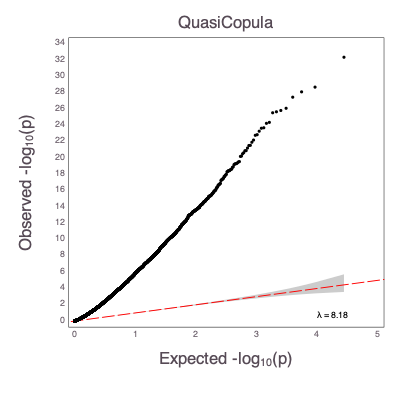

In [18]:
using MendelPlots
idx = findall(!isnan, qc_pvals)
success_pvals = qc_pvals[idx]
idx2 = findall(x -> x < 1e-50, success_pvals)
success_pvals[idx2] .= 1e-50
qq(success_pvals, dpi=80, titles="QuasiCopula")
display("image/png", read("qqplot.png"))

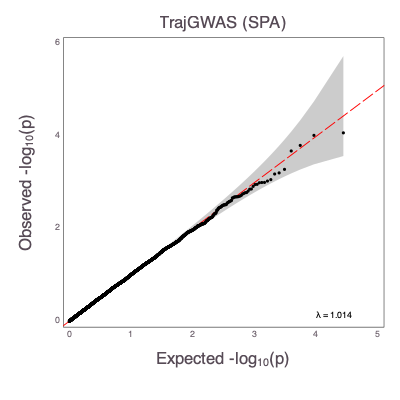

In [19]:
using MendelPlots
idx = findall(!isone, trajGWAS_result[!, "betapval"])
qq(trajGWAS_result[idx, "betapval"], dpi=80, titles="TrajGWAS (SPA)")
display("image/png", read("qqplot.png"))

# Binary trait comparison

In [25]:
function compare_power(
        nsims::Int,
        k::Int, 
        causal_snp_β,
    )
    qc_power = zeros(nsims)
    traj_score_power = zeros(nsims)
    traj_spa_power = zeros(nsims)
    qc_type1_err = zeros(nsims)
    traj_score_type1_err = zeros(nsims)
    traj_spa_type1_err = zeros(nsims)

    @showprogress for sim in 1:nsims
    
        # simulate from quasicopula model
        p = 15
        n = 10000
        plinkname = "test.data"
        qc_model, G, βtrue, θtrue, γtrue, τtrue = simulate_longitudinal_traits(
            n = n, # sample size
            d_min = 5, # min number of observations per sample
            d_max = 5, # max number of observations per sample
            p = p, # number of fixed effects, including intercept
            m = 2, # number of variance components
            q = 1000, # number of SNPs
            k = k, # number of causal SNPs
            seed = rand(1:100000),
            y_distribution = Normal,
            τtrue = 0.5,
            T = Float64,
            maf = 0.3,
            causal_snp_β = causal_snp_β,
            plinkdir = plinkname * ".bed",
        );

        # save plink bim/fam files
        open(plinkname * ".bim", "w") do f
            for i in 1:size(G, 2)
                write(f, "1\tsnp$i\t0\t$(100i)\t1\t2\n")
            end
        end
        open(plinkname * ".fam", "w") do f
            for i in 1:size(G, 1)
                write(f, "sample$i\t1\t0\t0\t1\t-9\n")
            end
        end

        # save phenotype file (make sure to not save intercept)
        data = zeros(5n, (p-1)+1) # (p-1) = covariates without intercept, +1 for response
        for (i, qc) in enumerate(qc_model.data)
            rowrange = (i-1)*5+1:5i
            data[rowrange, 1:end-1] .= qc.X[:, 2:end]
            data[rowrange, end]     .= qc.y
        end
        df_names = vcat(["cov$i" for i in 1:14], "y")
        df = DataFrame(data, df_names)
        df[!, "id"] = repeat(["sample$i" for i in 1:n], inner=5)
        CSV.write("test.data.response", df)

        cov_file = "test.data.response"
        gen_file = "test.data" # PLINK file without .bed/bim/fam extensions
        nullpath = "trajgwas.null.txt"
        pvalpath = "trajgwas.pval.txt"
        group_by = :id # rows with the same `group_by` are considered repeated meatures from sample subject

        # trajGWAS with SPA
        @suppress trajgwas(
            @formula(y ~ 1+cov1+cov2+cov3+cov4+cov5+cov6+cov7+cov8+cov9+cov10+cov11+cov12+cov13+cov14), # formula for mean effects
            @formula(y ~ 1), # formula for random effects
            @formula(y ~ 1), # formula for within-subject variance
            group_by,
            cov_file,
            gen_file,
            pvalfile = pvalpath, # output file for the gwas p-values
            nullfile = nullpath, # output file for the fitted null model
            usespa = true,       # use saddle point approximation or score test
            verbose = false
        )
        trajpval_spa = CSV.read(pvalpath, DataFrame)[!, "betapval"]

        # trajGWAS no SPA
        @suppress trajgwas(
            @formula(y ~ 1+cov1+cov2+cov3+cov4+cov5+cov6+cov7+cov8+cov9+cov10+cov11+cov12+cov13+cov14), # formula for mean effects
            @formula(y ~ 1), # formula for random effects
            @formula(y ~ 1), # formula for within-subject variance
            group_by,
            cov_file,
            gen_file,
            pvalfile = pvalpath, # output file for the gwas p-values
            nullfile = nullpath, # output file for the fitted null model
            usespa = false,       # use saddle point approximation or score test
            verbose = false
        )
        trajpval_score_test = CSV.read(pvalpath, DataFrame)[!, "betapval"]

        # QuasiCopula GWAS
        @suppress QuasiCopula.fit!(qc_model)
        qc_pvals, zscores = QuasiCopula.GWASCopulaVCModel(qc_model, G, check_grad=false);

        # compare power
        qc_power[sim] = compute_power(γtrue, qc_pvals)
        traj_score_power[sim] = compute_power(γtrue, trajpval_score_test)
        traj_spa_power[sim] = compute_power(γtrue, trajpval_spa)
        qc_type1_err[sim] = type1_error_rate(γtrue, qc_pvals)
        traj_score_type1_err[sim] = type1_error_rate(γtrue, trajpval_score_test)
        traj_spa_type1_err[sim] = type1_error_rate(γtrue, trajpval_spa)
    end
    
    return qc_power, traj_score_power, traj_spa_power, 
        qc_type1_err, traj_score_type1_err, traj_spa_type1_err
end

function compute_power(γtrue, pvals)
    length(γtrue) == length(pvals) || error("Check dimension")
    causal_idx = findall(!iszero, γtrue)
    discovered_idx = findall(x -> x < 0.05/length(pvals), pvals)
    power = length(discovered_idx ∩ causal_idx) / max(1, length(causal_idx))
    return power
end

function type1_error_rate(γtrue, pvals)
    length(γtrue) == length(pvals) || error("Check dimension")
    causal_idx = findall(!iszero, γtrue)
    discovered_idx = findall(x -> x < 0.05/length(pvals), pvals)
    FP = (length(discovered_idx) - length(discovered_idx ∩ causal_idx))
    FPR = FP / length(pvals)
    return FPR
end

type1_error_rate (generic function with 1 method)

## Effect size vs power/type1 error

In [36]:
# simulation parameters
nsims = 10
k = 10
β_causals = collect(0.001:0.002:0.05)

# storage
qc_powers, traj_score_powers, traj_spa_powers = zeros(length(β_causals)), zeros(length(β_causals)), zeros(length(β_causals))
qc_std, traj_score_std, traj_spa_std = zeros(length(β_causals)), zeros(length(β_causals)), zeros(length(β_causals))
qc_type1errs, traj_score_type1errs, traj_spa_type1errs = 
    zeros(length(β_causals)), zeros(length(β_causals)), zeros(length(β_causals))
qc_type1err_std, traj_type1err_score_std, traj_type1err_spa_std = zeros(length(β_causals)), zeros(length(β_causals)), zeros(length(β_causals))

@showprogress for (i, β_causal) in enumerate(β_causals)
    @suppress begin
        # run simulation
        qc_power, traj_score_power, traj_spa_power, 
            qc_type1err, traj_score_type1err, traj_spa_type1err = 
            compare_power(nsims, k, β_causal)

        # power
        qc_powers[i] = mean(qc_power)
        traj_score_powers[i] = mean(traj_score_power)
        traj_spa_powers[i] = mean(traj_spa_power)
        qc_std[i] = std(qc_power)
        traj_score_std[i] = std(traj_score_power)
        traj_spa_std[i] = std(traj_spa_power)

        # type 1 error
        qc_type1errs[i] = mean(qc_type1err)
        traj_score_type1errs[i] = mean(traj_score_type1err)
        traj_spa_type1errs[i] = mean(traj_spa_type1err)
        qc_type1err_std[i] = std(qc_type1err)
        traj_type1err_score_std[i] = std(traj_score_type1err)
        traj_type1err_spa_std[i] = std(traj_spa_type1err)
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:31:40


Power

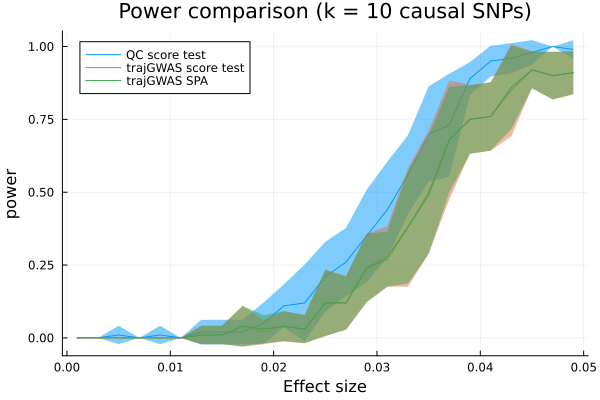

In [37]:
plt = Plots.plot(β_causals, qc_powers, ribbon=qc_std, label="QC score test",
    xlabel = "Effect size", ylabel="power", 
    title = "Power comparison (k = 10 causal SNPs)"
    )
Plots.plot!(plt, β_causals, traj_score_powers, label="trajGWAS score test", ribbon=traj_score_std)
Plots.plot!(plt, β_causals, traj_spa_powers, label="trajGWAS SPA", ribbon=traj_spa_std)
plt

In [40]:
[qc_powers traj_score_powers traj_spa_powers]

25×3 Matrix{Float64}:
 0.0   0.0   0.0
 0.0   0.0   0.0
 0.01  0.0   0.0
 0.0   0.0   0.0
 0.01  0.0   0.0
 0.0   0.0   0.0
 0.02  0.01  0.01
 0.02  0.01  0.01
 0.02  0.04  0.04
 0.05  0.02  0.03
 0.11  0.04  0.04
 0.12  0.03  0.03
 0.21  0.12  0.12
 0.26  0.12  0.12
 0.35  0.24  0.24
 0.44  0.28  0.27
 0.56  0.38  0.38
 0.7   0.5   0.49
 0.73  0.68  0.68
 0.89  0.75  0.75
 0.95  0.76  0.76
 0.96  0.85  0.86
 0.98  0.92  0.92
 1.0   0.9   0.9
 0.99  0.91  0.91

Type 1 error

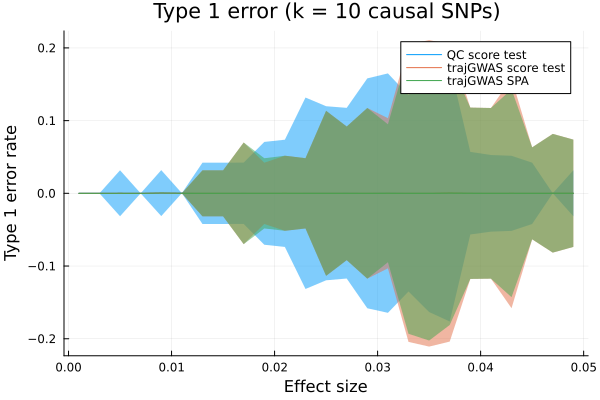

In [38]:
plt = Plots.plot(β_causals, qc_type1errs, ribbon=qc_std, label="QC score test",
    xlabel = "Effect size", ylabel="Type 1 error rate", 
    title = "Type 1 error (k = 10 causal SNPs)"
    )
Plots.plot!(plt, β_causals, traj_score_type1errs, label="trajGWAS score test", ribbon=traj_score_std)
Plots.plot!(plt, β_causals, traj_spa_type1errs, label="trajGWAS SPA", ribbon=traj_spa_std)
plt

In [41]:
10 .* [qc_type1errs traj_score_type1errs traj_spa_type1errs]

25×3 Matrix{Float64}:
 0.0    0.0    0.0
 0.0    0.0    0.0
 0.001  0.001  0.001
 0.0    0.0    0.0
 0.003  0.004  0.004
 0.002  0.001  0.001
 0.0    0.0    0.0
 0.0    0.0    0.0
 0.001  0.0    0.0
 0.0    0.0    0.0
 0.0    0.001  0.001
 0.001  0.0    0.0
 0.001  0.0    0.0
 0.002  0.0    0.0
 0.0    0.0    0.0
 0.003  0.001  0.001
 0.0    0.0    0.0
 0.0    0.0    0.0
 0.004  0.005  0.003
 0.002  0.001  0.001
 0.0    0.0    0.0
 0.0    0.001  0.001
 0.0    0.0    0.0
 0.001  0.001  0.001
 0.001  0.001  0.001